Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      10000 non-null  int64         
 1   merchant_id  10000 non-null  int64         
 2   amount       10000 non-null  float64       
 3   timestamp    10000 non-null  datetime64[ns]
 4   is_fraud     10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 390.8 KB
None

First 5 Rows:
   user_id  merchant_id      amount           timestamp  is_fraud
0      103          208   58.627962 2023-01-01 00:00:00         0
1      436          321    3.782501 2023-01-01 01:00:00         0
2      861          140  349.280425 2023-01-01 02:00:00         0
3      271          280   14.263615 2023-01-01 03:00:00         0
4      107           34   10.560720 2023-01-01 04:00:00         0

Fraud vs Non-Fraud Counts:
is_fraud
0    9811
1 

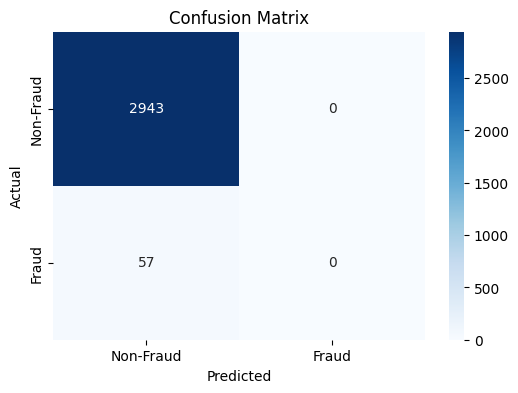

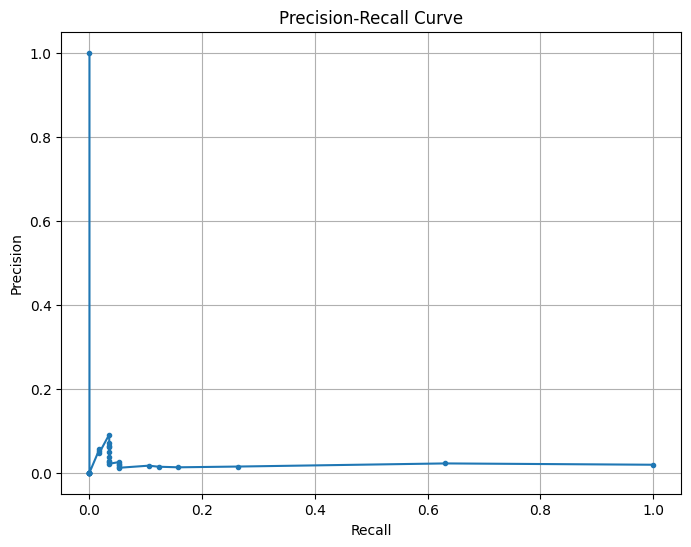


Feature Importance:
         feature  importance
0         amount    0.316682
1           hour    0.213631
4  merchant_freq    0.184685
3      user_freq    0.169160
2    day_of_week    0.115841


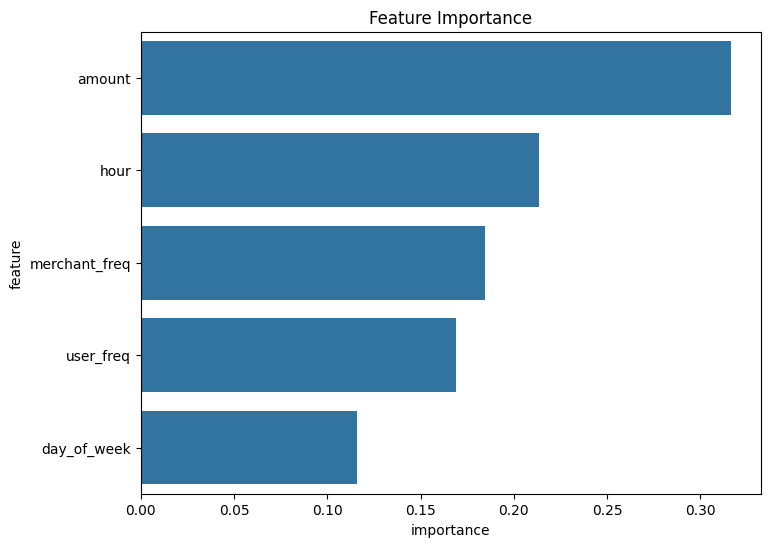


Number of False Positives: 0
Number of False Negatives: 57

Sample False Negatives (Top 5):
        amount  hour  day_of_week  user_freq  merchant_freq
7048 -0.053895    16            5  -0.031561       1.157825
9873 -0.404189     9            4   1.184653       0.233672
576  -0.370893     0            2  -0.639668       0.233672
3172 -0.384494     4            5  -1.247775      -0.921519
5304  0.382718     0            3  -0.335614       0.464710

Model saved as 'fraud_detection_model.pkl'. You can download it from the Files panel.


In [2]:
# Fraud Detection System in Google Colab
# Objective: Build a machine learning model to detect fraudulent transactions
# Dataset: Simulated transaction data (replace with your own dataset)
# Model: Random Forest Classifier
# Focus: Minimize false positives, maximize accuracy, explain misclassifications

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Step 2: Simulate a Dataset (Replace this with your own dataset)
# In practice, upload your dataset to Colab: Click "Files" -> "Upload" on the left panel
np.random.seed(42)
n_samples = 10000
data = {
    'user_id': np.random.randint(1, 1000, n_samples),
    'merchant_id': np.random.randint(1, 500, n_samples),
    'amount': np.random.lognormal(mean=4, sigma=1.5, size=n_samples),
    'timestamp': pd.date_range(start='2023-01-01', periods=n_samples, freq='H'),
    'is_fraud': np.random.choice([0, 1], size=n_samples, p=[0.98, 0.02])  # 2% fraud
}
df = pd.DataFrame(data)

# If you have your own dataset, upload it and load it like this:
# df = pd.read_csv('/content/your_dataset.csv')

# Step 3: Explore the Dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nFraud vs Non-Fraud Counts:")
print(df['is_fraud'].value_counts())

# Step 4: Preprocess the Data
# 4.1 Extract time-based features from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# 4.2 Handle categorical variables (user_id, merchant_id)
# For simplicity, we'll use frequency encoding
df['user_freq'] = df['user_id'].map(df['user_id'].value_counts())
df['merchant_freq'] = df['merchant_id'].map(df['merchant_id'].value_counts())

# 4.3 Drop original timestamp and IDs
df = df.drop(['timestamp', 'user_id', 'merchant_id'], axis=1)

# 4.4 Handle missing values (if any)
df.fillna(df.mean(), inplace=True)

# 4.5 Scale numerical features
scaler = StandardScaler()
df[['amount', 'user_freq', 'merchant_freq']] = scaler.fit_transform(df[['amount', 'user_freq', 'merchant_freq']])

# Step 5: Split Data into Features and Target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train the Random Forest Model
# Use class_weight='balanced' to handle imbalanced data
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
# 7.1 Predictions
y_pred = model.predict(X_test)

# 7.2 Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7.3 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7.4 Precision-Recall Curve to assess false positives
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Step 8: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Step 9: Explain Misclassifications
# Identify false positives and false negatives
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

print("\nNumber of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))

# Analyze false positives (legitimate transactions flagged as fraud)
if not false_positives.empty:
    print("\nSample False Positives (Top 5):")
    print(false_positives.head())

# Analyze false negatives (fraudulent transactions missed)
if not false_negatives.empty:
    print("\nSample False Negatives (Top 5):")
    print(false_negatives.head())

# Step 10: Save the Model (Optional)
# Save the model for future use
import joblib
joblib.dump(model, 'fraud_detection_model.pkl')

print("\nModel saved as 'fraud_detection_model.pkl'. You can download it from the Files panel.")